In [1]:
import pandas as pd
fhlo = pd.read_csv("../../../input_data/fully_hand_labelled_output.csv")

In [2]:
fhlo.Roken = fhlo.Roken.astype('category').cat.codes
fhlo.Alcohol = fhlo.Alcohol.astype('category').cat.codes
fhlo.Drugs = fhlo.Drugs.astype('category').cat.codes
fhlo["label"] = fhlo.Drugs
fhlo2 = fhlo[["text", "label"]]

In [3]:
train=fhlo2.sample(frac=0.8,random_state=200)
test=fhlo2.drop(train.index)

In [4]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [5]:
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaForSequenceClassification, AdamW, DataCollatorForLanguageModeling, Trainer, TrainingArguments

tokenizer = RobertaTokenizer.from_pretrained("jwouts/belabBERT_115k")

In [6]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis", model="Hielke/finetuned_belabBERT_drugs", tokenizer=tokenizer)


In [7]:
def predict(x):
    pred_y = classifier(x['text'][:512])
    if len(x['text']) <= 512:
        return pred_y[0]['label']
    highest_score = pred_y[0]['score']
    if pred_y[0]['label'] == 'LABEL_2':
        highest_score = 0
    for z in range(512, len(x['text']), 512):
        sliced_text = x['text'][z:(z+512)]
        new_pred_y = classifier(sliced_text)
        if new_pred_y[0]['label'] != 'LABEL_2':
            if new_pred_y[0]['score'] > highest_score:
                pred_y = new_pred_y
                highest_score = new_pred_y[0]['score']
    return pred_y[0]['label']

In [8]:
test['prediction'] = test.apply(lambda row: predict(row), axis=1)
test['prediction'] = test['prediction'].str[-1]
test['prediction'] = test['prediction'].astype('int')

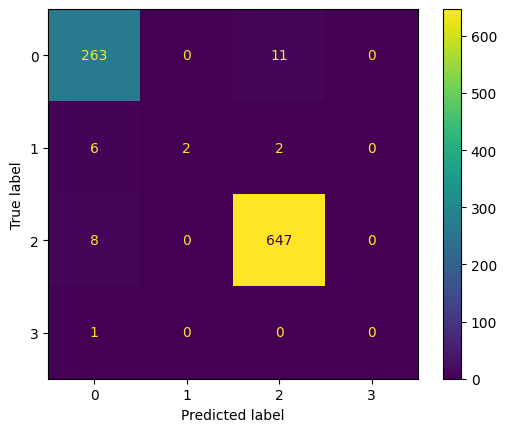

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       274
           1       1.00      0.20      0.33        10
           2       0.98      0.99      0.98       655
           3       0.00      0.00      0.00         1

    accuracy                           0.97       940
   macro avg       0.73      0.54      0.57       940
weighted avg       0.97      0.97      0.97       940



/home/hjmuizelaar/scriptie-310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hjmuizelaar/scriptie-310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hjmuizelaar/scriptie-310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt

cm = confusion_matrix(test['label'], test['prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(metrics.classification_report(test['label'], test['prediction']))

In [10]:
test.to_csv('belabbert_drugs_predictions.csv')